In [1]:
from sklearn.datasets import load_boston

boston = load_boston()

In [2]:
X = boston.data
y = boston.target

In [3]:
X.shape

(506, 13)

表明数据集有 $506$ 个样本，$13$ 个特征。我们看一个样本数据。

In [4]:
import numpy as np

np.set_printoptions(suppress=True)
X[0]

array([  0.00632,  18.     ,   2.31   ,   0.     ,   0.538  ,   6.575  ,
        65.2    ,   4.09   ,   1.     , 296.     ,  15.3    , 396.9    ,
         4.98   ])

In [5]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

## 模型训练

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()  # normalize=True
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('训练数据集上的评分', train_score)
print('测试数据集上的评分', test_score)

训练数据集上的评分 0.7608053462687876
测试数据集上的评分 0.633606971305561


效果很一般，这是因为其实数据不符合线性假设。

注意：**升维以后，要标准化以后，再送入线性回归算法**。

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


def polynomial_model(degree=2):
    polynomial_features = PolynomialFeatures(degree=degree)
    std_scaler = StandardScaler()
    linear_reg = LinearRegression()
    pipeline = Pipeline([('polynomial_features', polynomial_features),
                         ('std_scaler', std_scaler), ('linear_reg',
                                                      linear_reg)])
    return pipeline

In [10]:
model = polynomial_model(degree=2)

In [11]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [12]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('训练数据集上的评分', train_score)
print('测试数据集上的评分', test_score)

训练数据集上的评分 0.9470490143757466
测试数据集上的评分 0.7619004714651865


显然过拟合了。试试三阶多项式的预测效果。

In [13]:
model = polynomial_model(degree=3)
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('训练数据集上的评分', train_score)
print('测试数据集上的评分', test_score)

训练数据集上的评分 1.0
测试数据集上的评分 -211.68406875096133


过拟合更严重。

仅仅是 2 次多项式，就产生了 104 个特征。

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# include_bias=False 可以认为是特征的 0 次幂，就是 1
polynomial_fea = PolynomialFeatures(degree=2, include_bias=False)
polynomial_fea_data = polynomial_fea.fit_transform(X_train)

原始 X_train 的特征个数。

In [15]:
X_train.shape[1]

13

特征提升以后的 X_train 的特征个数。

In [16]:
polynomial_fea_data.shape[1]

104

## 绘制学习曲线

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np


def plot_learning_curve(plt,
                        estimator,
                        title,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r")
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g")
    plt.plot(
        train_sizes,
        train_scores_mean,
        'o--',
        color="r",
        label="Training score")
    plt.plot(
        train_sizes,
        test_scores_mean,
        'o-',
        color="g",
        label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<Figure size 3600x800 with 0 Axes>

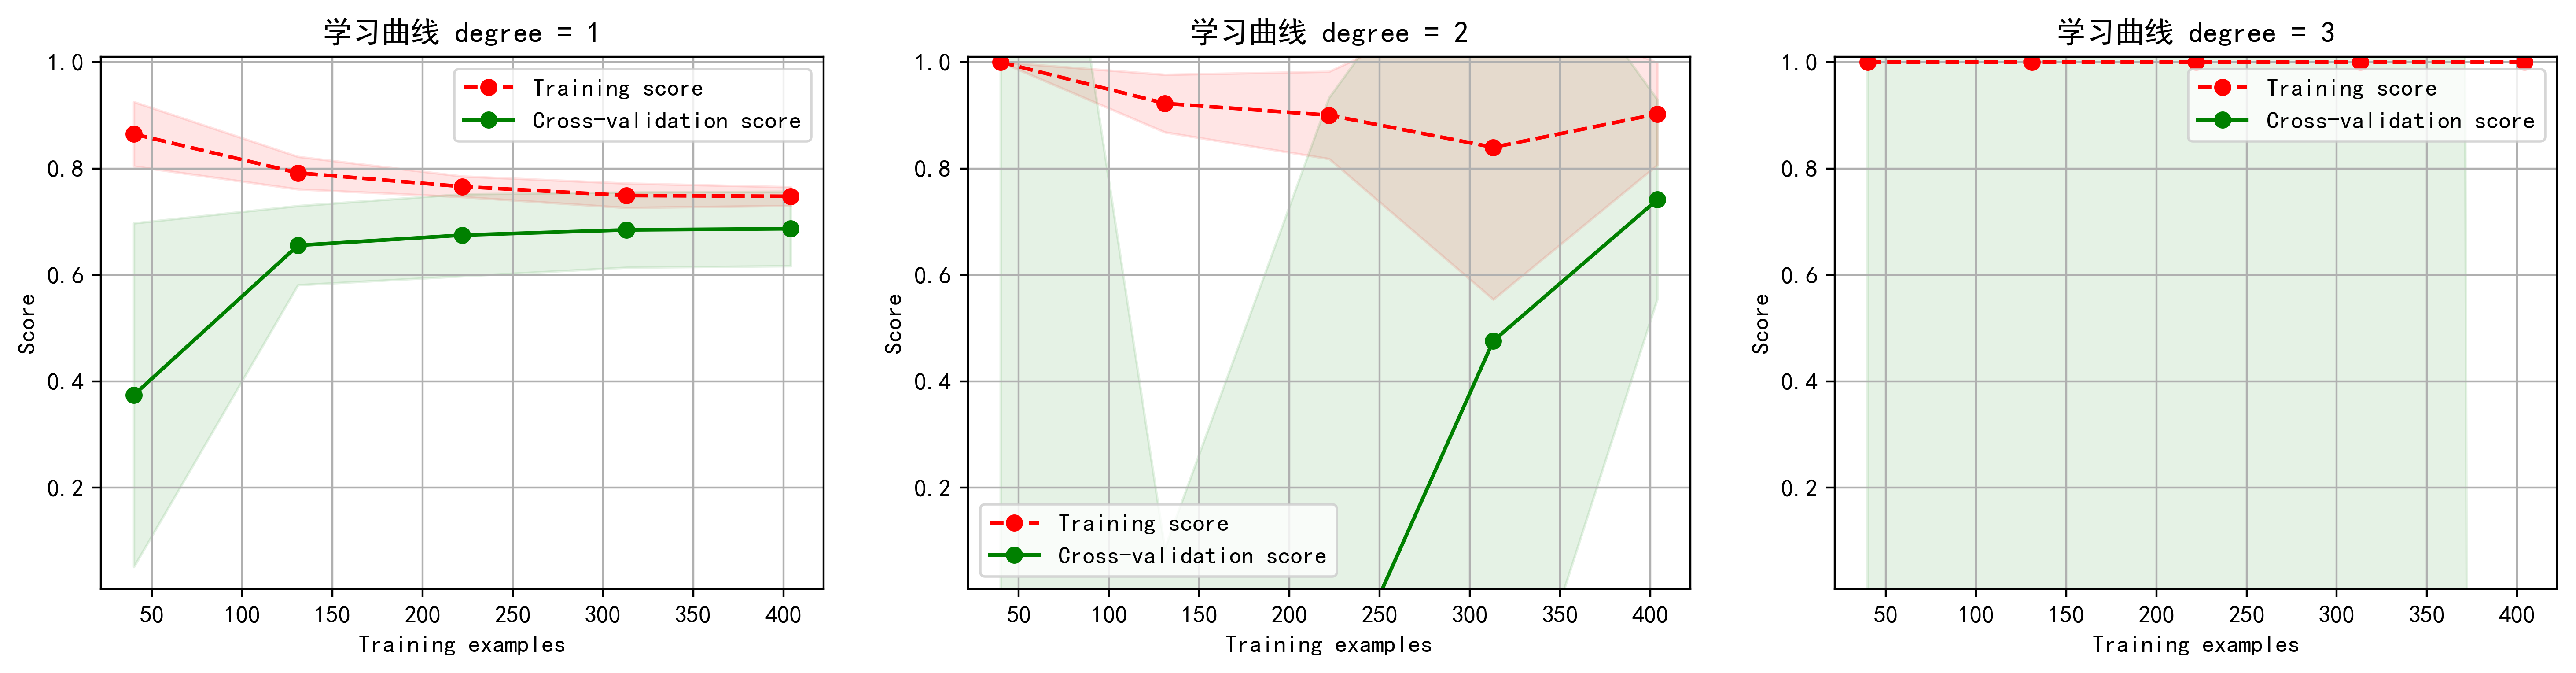

In [18]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(18, 4), dpi=200)
title = '学习曲线 degree = {0}'

degrees = [1, 2, 3]
plt.figure(figsize=(18, 4), dpi=200)
for i in range(len(degrees)):
    plt.subplot(1, 3, i + 1)
    plot_learning_curve(
        plt,
        polynomial_model(degrees[i]),
        title.format(degrees[i]),
        X,
        y,
        ylim=(0.01, 1.01),
        cv=cv)
plt.show()